In [21]:
#CONFIG VALUES
look_back = 500

In [22]:
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras import metrics
from scipy.signal import lfilter

In [23]:
# Check python version - should be 3.5.*
from platform import python_version

print(python_version())

3.5.4


In [24]:
# OLD MODEL
# Look back is the amount of samples in the past the network takes into consideration
#model = Sequential()
#model.add(LSTM(8, input_shape=(1, look_back)))
#model.add(Dense(1))
#model.compile(loss='mean_squared_error', optimizer='adam')

In [25]:
# NEW MODEL
model = Sequential()
model.add(LSTM(input_dim=look_back,output_dim=look_back*2,return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(look_back*2,return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(1))
model.add(Activation("linear"))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

/Users/fuchs/anaconda3/envs/python35/lib/python3.5/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/fuchs/anaconda3/envs/python35/lib/python3.5/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=1000, input_shape=(None, 500..., return_sequences=True)`
  This is separate from the ipykernel package so we can avoid doing imports until


In [26]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [27]:
def smooth_data(data, smoothness):
    b = [1.0 / smoothness] * smoothness
    a = 1
    return lfilter(b,a,data)

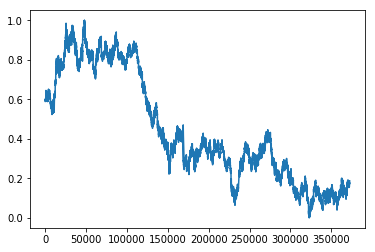

In [28]:
numpy.random.seed(7)
# load dataset
dataframe = read_csv('eurusd2018.csv', usecols=[2], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')

# normalize
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
#print(dataset)
#dataset = smooth_data(dataset, 50000)
plt.plot(dataset)
plt.show()
# split into train and test sets
train_size = int(len(dataset) * 0.4)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# do some reshaping
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

#trainY = smooth_data(trainY,10)
#testY = smooth_data(testY,10)
#trainX = smooth_data(trainX,10)
#testX = smooth_data(testX,10)

# reshape input 
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [9]:
model.fit(trainX, trainY, epochs=2, batch_size=50, verbose=1)

Epoch 1/2
 31250/148541 [=====>........................] - ETA: 2:21:22 - loss: 0.0022 - acc: 0.0000e+00

KeyboardInterrupt: 

In [10]:
model.save('model_lb200_1.h5')

Input:


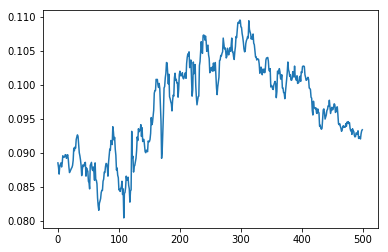

Prediction and reference:


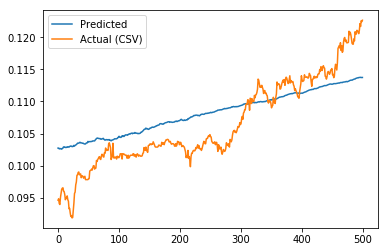

In [20]:
position = 56
a = numpy.array([])
for i in range(0,look_back):
    a = numpy.append(a, testX[len(testX)-look_back*position-1][0][i])

print("Input:")
#print(a)
plt.plot(a)
plt.show()

predicted = numpy.array([])
for i in range(0,look_back):
    nextPredictionData = numpy.array([[a]])
    prediction = model.predict(nextPredictionData)
    predicted = numpy.append(predicted, prediction[0])
    a = numpy.delete(a,0,0)
    a = numpy.append(a, prediction[0])


reference = testX[len(testX)-look_back*(position-1)-1][0]
#print(predicted)
#print(reference)

print("Prediction and reference:")
plt.plot(predicted, label='Predicted')
plt.plot(reference, label='Actual (CSV)')
plt.legend(loc='upper left')
plt.show()
